In [1]:
# from qiskit import *
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
from numpy import random
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
# from qiskit.aqua.components.optimizers import *
from graber import GRABER
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PyQuanteDriver, UnitsType, BaseDriver
from qiskit.chemistry import FermionicOperator
import time

In [2]:
def get_qubit_op(dist):
    driver = PyQuanteDriver(atoms="Li .0 .0 .0; H .0 .0 " + str(dist), units=UnitsType.ANGSTROM,
                         charge=0)
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
start = time.time()
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 3.5, 0.1)
exact_energies = []
vqe_energies = []
# optimizer = SLSQP(maxiter=5)
optimizer = GRABER()
initial_point = None

for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity')
    
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer, initial_point = initial_point)
    vqe_result = np.real(vqe.run(backend)['eigenvalue']+shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    #current = var_form.construct_circuit(vqe.optimal_params)
    current = vqe.optimal_params
    initial_point = current
    print(vqe._ret['num_optimizer_evals'])
print("All energies have been calculated")
end = time.time() -start
print(end)

Interatomic Distance: 0.5 VQE Result: -7.028409956821977 Exact Energy: [-7.03973238]
2
Interatomic Distance: 0.6 VQE Result: -7.299540961120479 Exact Energy: [-7.31334574]
2
Interatomic Distance: 0.7 VQE Result: -7.485944787683806 Exact Energy: [-7.50092201]
2
Interatomic Distance: 0.8 VQE Result: -7.615770093914689 Exact Energy: [-7.63097818]
2
Interatomic Distance: 0.9 VQE Result: -7.705753284033747 Exact Energy: [-7.72081235]
2
Interatomic Distance: 1.0 VQE Result: -7.767362100103378 Exact Energy: [-7.78224236]
2
Interatomic Distance: 1.1 VQE Result: -7.808743149183102 Exact Energy: [-7.82359925]
2
Interatomic Distance: 1.2 VQE Result: -7.83561580417955 Exact Energy: [-7.85069835]
2
Interatomic Distance: 1.3 VQE Result: -7.851953844825863 Exact Energy: [-7.86756327]
2
Interatomic Distance: 1.4 VQE Result: -7.860538647078238 Exact Energy: [-7.87700148]
2
Interatomic Distance: 1.5 VQE Result: -7.863357623256011 Exact Energy: [-7.88101572]
2
Interatomic Distance: 1.6 VQE Result: -7.861

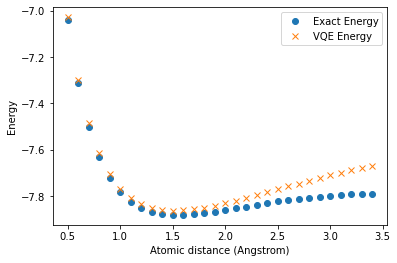

In [6]:
plt.plot(distances, exact_energies, 'o', label="Exact Energy")
plt.plot(distances, vqe_energies, 'x', label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

[ 0.24465577  1.08143314  1.46385088 -7.87276388]
0.2446557674996625 *((1-np.exp(- 1.0814331434140916  * (x- 1.463850879475121 )))**2) +  -7.872763881625702


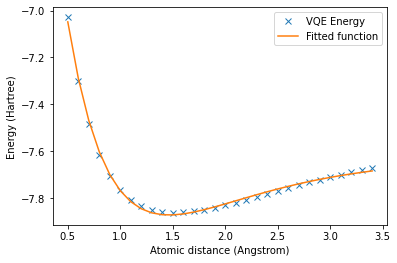

In [9]:
from scipy import optimize

#V (r) = De(1 − e−α(r−r0))^2
def test_func(x, a, b, c, d):
    return a * ((1- np.exp(-b*(x-c)))**2) + d

params, params_covariance = optimize.curve_fit(test_func, distances, vqe_energies, p0=[1, -1, -1.9, -7.9])

print(params)
print(params[0], "*((1-np.exp(-", params[1], " * (x-", params[2], ")))**2) + ",params[3])

fitted_energies = []
for i in range(len(exact_energies)):
#     print(test_func(distances[i], params[0], params[1], params[2]))
    fitted_energies.append(test_func(distances[i], params[0], params[1], params[2], params[3]))
    
#plt.plot(distances, exact_energies, 'o', label="Exact Energy")
plt.plot(distances, vqe_energies, 'x', label="VQE Energy")
plt.plot(distances, fitted_energies,label='Fitted function')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend(loc='best')
plt.show()

In [ ]:
D_e = params[0] #hartree
alpha = params[1] #angstrom
r_0 = params[2] #angstrom

def reduced_mass(m_1,m_2):
    mu_inv = (1/m1) + (1/m2)
    return mu_inv**-1

